# Introduction



CIS 5450 - Big Data Analytics <br>
Final Project <br>


---
Authors: <br>
&emsp;Ben Menko - bmmenko@seas.upenn.edu <br>
&emsp;Mukul Anand - mukula@sas.upenn.edu <br>
&emsp;Karthikeya Jayarama - jkarthik@seas.upenn.edu <br>


---



In 2023, hundreds of millions of people in the United States consumed a total of around [27,400,000,000 megawatt-hours of electricity](https://css.umich.edu/publications/factsheets/energy/us-energy-system-factsheet). Over the past several decades, the world has become helplessly dependent on electric power, and it is a vacuous truth that the world would be very different if it weren't for the time, effort, and trillions of dollars that are constantly being allocated towards providing this energy.
<br><br>
In the context of energy production, **load** refers to the total MWh demanded by the electric grid at any given time. Power companies have a crucial duty to ensure that they produce the demanded load 24/7/365. Otherwise, blackouts can occur, such as the [Northeast blackout of 2003](https://www.energy.gov/oe/august-2003-blackout), which inadvertently resulted in the deaths of around 100 people.
<br><br>
Therefore, **load forecasting** is a problem within data analytics that can literally save lives. When power companies can precisely predict how load will change over time, they can make [well informed business decisions that ensure our safety while maintaining minimal costs](https://www.sas.com/en_us/insights/articles/load-forecasting.html). To this end, precise short-term forecasts (7-14 days) are the most important tool for enabling these companies to optimally schedule electricity production.
<br><br>
While there are many variables at play, weather is one of the strongest predictors of load demand. In this notebook, we assess several models predicting short-term load from weather data. Additionally, we will compare our model to [PJM's](https://www.pjm.com/about-pjm/who-we-are) state-of-the-art model to evaluate/explain the discrepancies.

**Terminology and guiding principles**<br>




---

**Grid**: the network of electrical generators, substations, transmission lines, end-cosumers, and other supporting infrastructure.
<br><br>
**Load demand**: a measurement of the total electrical power consumed by the grid.
<br><br>
**Generator units**: generic term covering all electricity generating power plants, such as coal plants, combustion turbines, nuclear facilities, hydroelectric damns, solar panels, etc. Units typically have an associated efficiency curve, which defines the range where they balance energy production with operating costs. Units operating at full capacity or minimal capacity will not be running efficiently.
<br><br>
**Weather features/variables**: environmental data, such as temperature, that can be used to predict load demand
<br><br>
**Temporal features/variables**: obervable trends over time that relate to load demand (e.g. load demand is higher during the day than at night)
<br><br>
**Asymetry of forecasting error**: the monetary cost of under-forecasting load is greater than the cost of over-forecasting load. Under-serving load can cause blackouts, so when load is under-forecasted, power companies have to scramble to spin-up generating units, which is very expensive due to these units operating at extreme ends of their efficiency curves. It is better to be over-prepared and let some of the produced energy go to waste.
<br><br>
**Forecast horizon**: the period of time into the future which a model intends to forecast. Load forecasting is typically short (7-14 days), medium (6-24 months), or long (many years) term, with each avenue requiring vastly different modeling approaches. Short-term forecasts target maximum precision whereas long-term forecasts are inteded to capture general trends.
<br><br>
**Short-term load forecasting**: for this project, we focus on short-term forecasts. These forecasts are crucial for power companies as they are a key tool for informing production schedules - i.e. planning which units need to run in each hour to meet load demand while maintaining minimal costs.
<br><br>
**Forecast decay**: a phenomenon inherent to forecasting where the accuracy of forecasts is expected to decrease over time due to heightened uncertainty as the horizon lengthens

# Importing libraries and datasets


The first step is to import the libraries we use throughout the notebook.

In [ ]:
# data processing libraries
import pandas as pd
import numpy as np
from datetime import datetime
import calendar

# model librarires
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
!pip install xgboost --quiet
import xgboost as xgb

# pytorch libraries
!pip install pytorch-forecasting --quiet
from pytorch_forecasting import Baseline, EncoderNormalizer, TemporalFusionTransformer, TimeSeriesDataSet,DeepAR
import torch
from pytorch_forecasting.metrics import MAE, RMSE, MAPE
import lightning.pytorch as pl
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# plotting libraries
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp

# utilities libraries
from itertools import product
import time
import warnings
import logging

# hide warnings and logs
warnings.filterwarnings("ignore")
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

We can find historical load values from PJM's [online open database](https://dataminer2.pjm.com/feed/hrl_load_prelim/definition). We will pair this data with historical weather data from[ OpenMeteo's Historical Weather API](https://open-meteo.com/en/docs/historical-weather-api) in order to train our models.

For this project, we take load data pertaining to PJM's MIDATL service area from 2018-2023. Weather data is aggregated from 5 cities within this service area: Philadelphia, Scranton, Eerie, Pittsburgh, and Washington D.C.

All data is collected at an hourly temporal resolution.

Raw data files can be found in the `data` folder of the repository.

# Data Wrangling


In this section, we take the necessary steps towards reading our data from the downloaded files and joining them into a primary dataframe.

First, we deal with reading, aggregating, and cleaning our weather data.

In [4]:
# read weather data
full_weather_df = pd.read_csv('./data/weather/full_weather.csv', skiprows=7)

# reformat date column
full_weather_df['time'] = pd.to_datetime(full_weather_df['time']).dt.strftime('%-m/%-d/%Y %-I:%M:%S %p')

# save chronological ordering of rows
full_weather_df['order'] = full_weather_df.reset_index().index
save_order = full_weather_df[full_weather_df['location_id'] == 0]
save_order = save_order[['time', 'order', 'is_day ()']]

# aggregate weather data as min/max/mean
aggregated_weather_df = full_weather_df.drop(columns=['location_id', 'order', 'is_day ()'], inplace=True)
aggregated_weather_df = full_weather_df.groupby('time').agg(['min', 'max', 'mean'])
aggregated_weather_df.columns = [' '.join(col) for col in aggregated_weather_df.columns]

# sort chronologically
aggregated_weather_df = aggregated_weather_df.merge(save_order, on='time')
aggregated_weather_df.sort_values(by='order', inplace=True)
aggregated_weather_df.drop(columns=['order'], inplace=True)

# rename columns
aggregated_weather_df.rename(columns={'time': 'datetime_beginning_ept', 'is_day ()' : 'is_day'}, inplace=True)

# drop last 24 hours (01/01/2024)
aggregated_weather_df = aggregated_weather_df.iloc[:-24]

# round all values to 5 decimal points
aggregated_weather_df = aggregated_weather_df.round(5)

# reset index
aggregated_weather_df.reset_index(inplace=True, drop=True)


Next, we will read, filter, and clean the load data.

In [5]:
# list of load years
load_years = ['2018', '2019', '2020', '2021', '2022', '2023']

# read load data into combined dataframe
combined_load_df = pd.DataFrame()
for year in load_years:
  combined_load_df = pd.concat([combined_load_df, pd.read_csv(f'./data/load/load_{year}.csv')])

# we are focused on MIDATL region
combined_load_df = combined_load_df[combined_load_df['load_area'] == "MIDATL"]
# drop unnecessary columns
combined_load_df.drop(columns=['datetime_beginning_utc', 'datetime_ending_utc', 'datetime_ending_ept', 'load_area'], inplace=True)
combined_load_df.reset_index(drop=True, inplace=True)
combined_load_df.drop_duplicates(inplace=True)


Next, we join weather and load data by datetime.

In [ ]:
# join weather and load
prelim_df = combined_load_df.merge(aggregated_weather_df, on='datetime_beginning_ept')

Next, we will clean the joined dataframe and augment with encodings of temporal variables.


In [ ]:
# One-hot encodings
primary_df = prelim_df.copy()

# ensure dateimte column is of type datetime
primary_df['datetime_beginning_ept'] = pd.to_datetime(primary_df['datetime_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')

# set datetime as the index
primary_df.set_index('datetime_beginning_ept', inplace=True)

# ensure datetime is sorted
primary_df.sort_index(inplace=True)

# specify frequency of datetime columns
primary_df = primary_df[~primary_df.index.duplicated(keep='first')]
primary_df = primary_df.asfreq('h')

# create time-based features
primary_df['hour'] = primary_df.index.hour
primary_df['day_of_week'] = primary_df.index.dayofweek
primary_df['month'] = primary_df.index.month
primary_df['is_weekend'] = primary_df.index.dayofweek.isin([5,6]).astype(int)

# one-hot encode categorical features
categorical_cols = ['hour', 'day_of_week', 'month']
primary_df = pd.get_dummies(primary_df, columns=categorical_cols)
primary_df.reset_index(inplace=True)


The initial data wrangling is complete; however, there are a few outliers in our load values. Printing the load values in descending order quickly helps us identify a reasonable cutoff.

In [ ]:
loads = primary_df['prelim_load_avg_hourly']
# sort
sorted = loads.sort_values(ascending=False)
print(sorted.head(15))

17030    380162.4
19919    202809.3
22529    174882.1
22194    165857.7
22691    162924.6
22690    160620.8
22451    160081.0
22928     95914.2
5777      57152.4
4385      57009.6
13601     57000.3
30641     56971.3
5776      56913.1
40360     56829.3
30640     56825.1
Name: prelim_load_avg_hourly, dtype: float64


We can see a massive jump between values in the 50,000s and values above 95,000. Although these data may be legitimate, they represent anomalies which are not representative of the area we are trying to model. Our best option will be to drop these values exceeding 95,000 and proceed with a forward fill.

In [ ]:
# identify outliers (where the value is greater than or equal to 80000)
primary_df['prelim_load_avg_hourly_outlier'] = primary_df['prelim_load_avg_hourly'] >= 95000
# set outliers to NaN
primary_df.loc[primary_df['prelim_load_avg_hourly_outlier'], 'prelim_load_avg_hourly'] = np.nan
# drop temporary column
primary_df.drop(columns=['prelim_load_avg_hourly_outlier'], inplace=True)
# forward fill any missing values
primary_df = primary_df.ffill()


Lastly, we can print out the dataframe's dimensions, showing that we meet the project requirements.

In [ ]:
print("Number of rows:", len(primary_df))
print("Number of columns:", len(primary_df.columns))

Number of rows: 52584
Number of columns: 74


# Exploratory Data Analysis

### Data Summary

We can start by taking a look at some basic summary statistics to get a sense for the data we are working with.

In [ ]:
# range, average, stdev values in each column
summ_df = primary_df[['prelim_load_avg_hourly', 'temperature_2m (°F) mean','apparent_temperature (°F) mean', 'relative_humidity_2m (%) mean', 'precipitation (inch) mean', 'surface_pressure (hPa) mean', 'cloud_cover (%) mean', 'wind_speed_10m (m/s) mean', 'shortwave_radiation (W/m²) mean', 'direct_radiation (W/m²) mean']].copy()

summary = pd.DataFrame({
    'Range': summ_df.max()-summ_df.min(),
    'Mean': summ_df.mean(),
    'Standard Deviation': summ_df.std()
})
print(summary)

                                      Range          Mean  Standard Deviation
prelim_load_avg_hourly           38407.0000  30868.525169         6301.885273
temperature_2m (°F) mean            97.6000     54.005980           17.655106
apparent_temperature (°F) mean     115.4400     50.949121           22.328949
relative_humidity_2m (%) mean       76.8000     71.691165           15.810776
precipitation (inch) mean            0.3258      0.006109            0.014882
surface_pressure (hPa) mean         56.2600   1000.836792            6.872537
cloud_cover (%) mean               100.0000     47.376540           28.762984
wind_speed_10m (m/s) mean            9.6680      3.279253            1.345157
shortwave_radiation (W/m²) mean    978.4000    164.713533          233.518125
direct_radiation (W/m²) mean       865.8000    104.472988          171.310430


The main takeway from these summary statistics is that our features take on different magnitudes of values. Therefore, we will scale this data so that features are weighed equally in training.

### Correlation Matrix: Figure 1


The goal here is to identify highly correlated variables, so we can make informed decisions about which features to include in our models.

In [ ]:
## Correlation Matrix
correlation_matrix = summ_df.corr()

fig = go.Figure(data=go.Heatmap(
   z=correlation_matrix,
   x=correlation_matrix.columns,
   y=correlation_matrix.index,
   colorscale='RdBu_r',
   text=correlation_matrix.round(2),
   texttemplate='%{text}',
   textfont={"size": 10},
   hoverongaps=False
))

fig.update_layout(
   width=800,
   height=800,
   title='Correlation Matrix Heatmap',
   xaxis_title='',
   yaxis_title=''
)

We can see that there is very high correlation in the following pairs: <br>

- shortwave radiation and direct radiation

- apparent temperature and 2m temperature


For models that are impacted by multicolinearity of input features, we must be sure to drop one of these features for each pair.

### Load vs. Weather features: Figure 2


In this section, we explore the relationship between load and temperature. The goal is to expose how weather patterns impact load demand in order to make informed decisions about how to utilize weather features in our models.

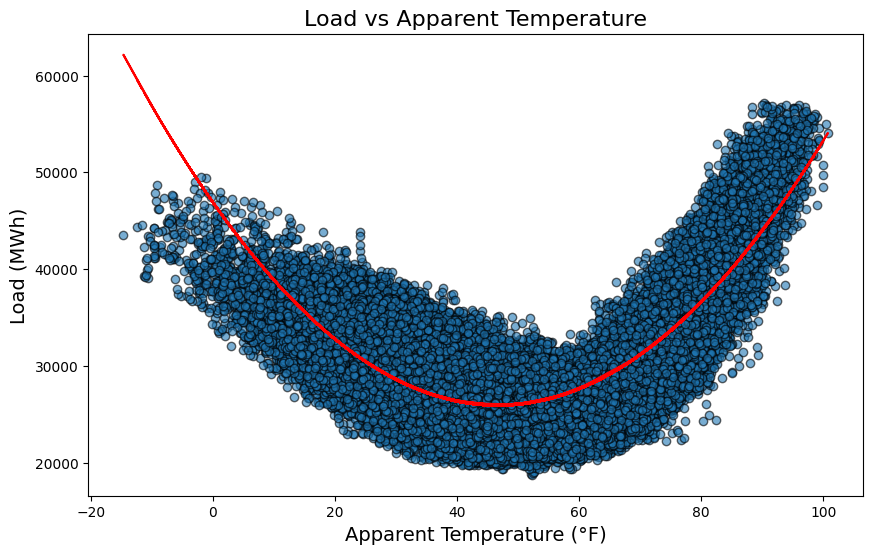

In [ ]:
load = primary_df['prelim_load_avg_hourly']  # Electric load demand
temperature = primary_df['apparent_temperature (°F) mean']  # Temperature data

# Scatter plot: Load vs. Temperature
plt.figure(figsize=(10, 6))
plt.scatter(temperature, load, alpha=0.6, edgecolors='k')
plt.title('Load vs Apparent Temperature', fontsize=16)
plt.xlabel('Apparent Temperature (°F)', fontsize=14)
plt.ylabel('Load (MWh)', fontsize=14)
plt.grid(False)
p = np.poly1d(np.polyfit(temperature, load, 2)) # Quadratic Trend Line
plt.plot(temperature, p(temperature), color = "red")
plt.show()


While there is a significant spread, an obvious pattern emerges. We can see that load is minimized at around 50 degrees farenheit. Conversely, load demand increases as we approach the extreme ends of the spectrum.

The real world explanation for this pattern is quite intuitive. Generally, people can turn off air-conditioning and/or spend more time outdoors when the weather is comfortable. On the extreme ends of the spectrum, people require more air-conditioning and are more likely to fall back to energy-consuming pasttimes, such as cooking, watching TV, or playing videogames.

This relationship shows up most clearly if we focus on apparent temperature, but in reality, it is a combination of weather variables that produce this phenomenon. For example, the temperature may be in the ideal range, but if there is a thunderstorm occuring, people will still stay inside. In our modeling, we hope to capture the ways in which weather features collectively influence energy demand.

### Load vs. Time: Figure 3


Additionally, there are several temporal variables that affect demand. For the next figure, we show the average load for each hour of the day, grouped by month. The goal is to expose how load changes over time, so we can deduce which patterns we need our models to capture.

In [ ]:
# graph average load by hour for each month
datetime_df = primary_df.copy()
datetime_df['datetime_beginning_ept'] = pd.to_datetime(datetime_df['datetime_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')
datetime_df['month'] = datetime_df['datetime_beginning_ept'].dt.month
datetime_df['hour'] = datetime_df['datetime_beginning_ept'].dt.hour
average_load = datetime_df.groupby(['month','hour'])['prelim_load_avg_hourly'].mean().reset_index()
average_load['month'] = average_load['month'].apply(lambda x: calendar.month_name[x])
pivot_table = average_load.pivot(index='hour',columns='month',values='prelim_load_avg_hourly')
month_names = pivot_table.columns

fig = go.Figure()
colors = px.colors.qualitative.Light24
for i, month in enumerate(month_names):
   fig.add_trace(go.Scatter(
       x=pivot_table.index,
       y=pivot_table[month],
       name=month,
       line=dict(color=colors[i % len(colors)])
   ))

fig.update_layout(
   title='Average Load by Hour for Each Month',
   xaxis_title='Hour of the Day',
   yaxis_title='Average Load',
   width=1000,
   height=600,
   showlegend=True,
   legend=dict(
       title="Month",
       yanchor="top",
       y=1,
       xanchor="right",
       x=1.15
   )
)

fig.show()

This graph neatly exposes the key timeseries trends we hope to utilize in our models.

Hourly trend:

- Load typically peaks in the early evenings and troughs in the early morning.
  - Peak is explained by people coming home from work, turning on air-conditioning, televisions, microwaves, etc.
  - Trough is explained by most people being asleep at these hours

Monthly trend:

- We can see that our hottest months (June, July, August) result in higher energy demand during peak hours
  - Demand for AC and indoor activities goes up when it is excessively hot outside

- Converse, our coldest months (January, February, December) tend to result in higher energy demand during trough hours
  - Demand for heating is high during these Winter months, even while people are sleeping

### Weather Aggregation: Figure 4

Lastly, lets take a look at our weather variables. We intitally pulled weather data from 5 stations within the Mid-Atlantic service area, and we need to choose the best way to aggregate the data. For normally distributed data, the mean will suffice. For highly skewed data, our models may be able to glean more information from taking the minimum or maximum value. Lets take a look at the spread of the data points.

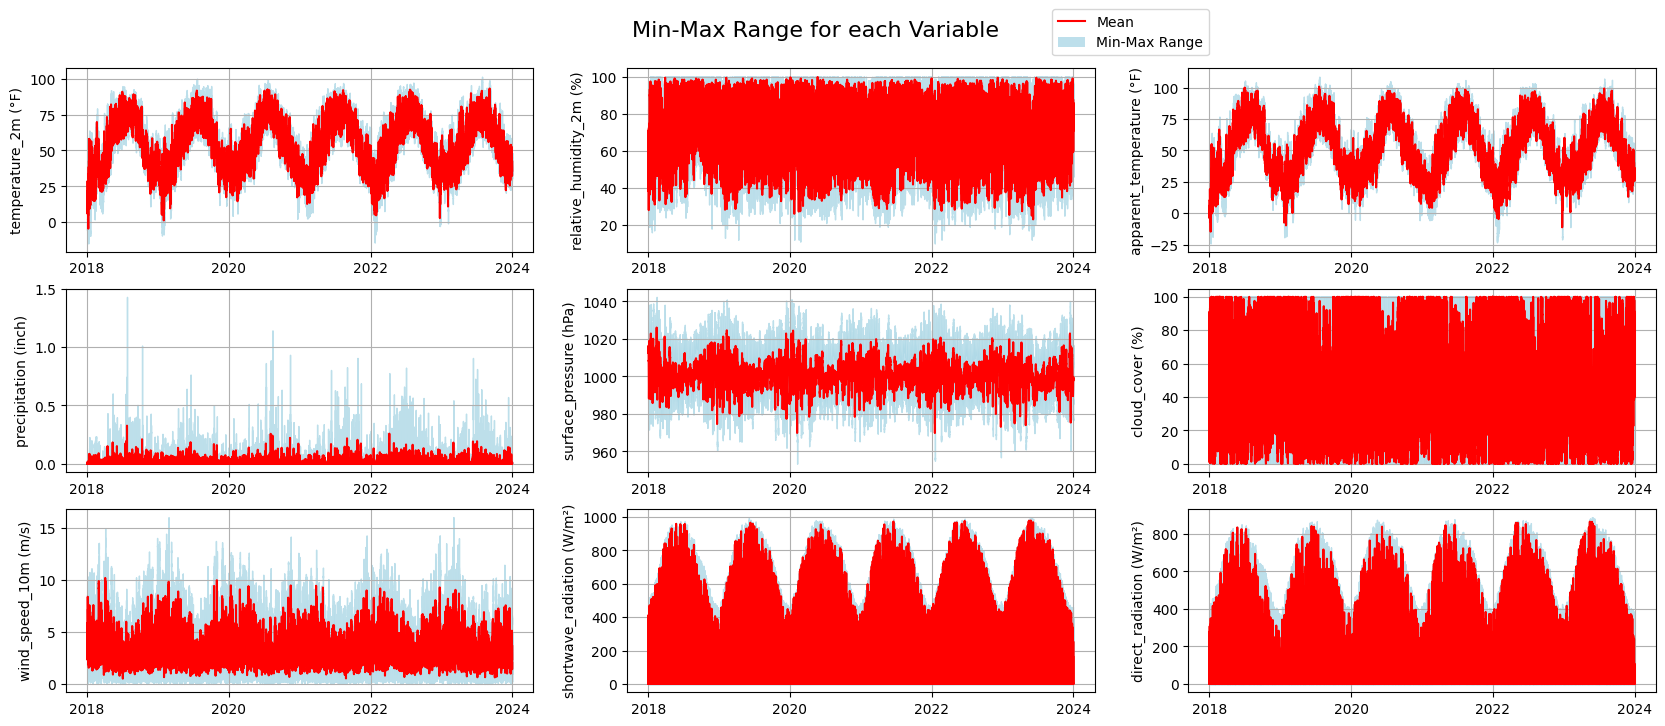

In [ ]:
# define the weather variables
variables = [
    'temperature_2m (°F)', 'relative_humidity_2m (%)', 'apparent_temperature (°F)',
    'precipitation (inch)', 'surface_pressure (hPa)', 'cloud_cover (%)',
    'wind_speed_10m (m/s)', 'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)'
]

# set up subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 8))
fig.suptitle('Min-Max Range for each Variable', size=16, y=0.95)
legend_elements = [
    plt.Line2D([0], [0], color='red', label='Mean'),
    plt.Rectangle((0,0), 1, 1, fc='lightblue', alpha=0.8, label='Min-Max Range')
]

# plot max/min around the mean for each weather variable
for idx, (var, ax) in enumerate(zip(variables, axes.flat)):
    min_col = f"{var} min"
    max_col = f"{var} max"
    mean_col = f"{var} mean"

    ax.plot(datetime_df['datetime_beginning_ept'], datetime_df[mean_col],
            color='red')
    ax.fill_between(datetime_df['datetime_beginning_ept'],
                   datetime_df[min_col], datetime_df[max_col],
                   color='lightblue', alpha=0.8)

    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.set_ylabel(var)
    ax.grid()

fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.7, 0.935))

plt.subplots_adjust(right=0.92, top=0.89)
plt.show()

From these graphs we can conclude that using the mean value of each variable will suffice as an aggregation of the weather data across the five stations. The exception to this rule is precipitation, where we will instead use the maximum since the maximum value will give our models more information to work with.

# Base Model - Linear Regression



### Preprocess the data

We start with some basic preprocessing, which in this case is a simple matter of selecting the correct columns for training.

In [ ]:
# Create copy of dataframe
lr_df = primary_df.copy()

# keep only mean weather variables, but use max precipitation
lr_df = lr_df.loc[:, lr_df.columns.str.contains('is_|hour_|day_of|month_|mean|prelim_load_avg_hourly') | lr_df.columns.str.contains('precipitation \(inch\) max')]
# drop highly correlated features
lr_df = lr_df.drop(columns=['precipitation (inch) mean', 'apparent_temperature (°F) mean', 'direct_radiation (W/m²) mean'])


### Training

Training and testing this model requires a nuanced approach. For our experiments, we are focused on generating precise two-week forecasts. In the real-world, a model like this would be run daily and constantly updated with the most recent data.

This is a forecasting model and necessarily differs from other classifiers/regression models. We need to train on consecutive sequences of historic data and predict consecutive sequences of future data.

Our training/testing should reflect these circumstances, but we definitely **don’t** want to just train on the first 52,248 hours and test on the last 336 (last two weeks).

A simple grid search that only gauges performance on a single two-week period will not suffice, as it may end up overfit to that particular testing window. Instead, our grid-search will need to incorporate timeseries cross-validation  to ensure that we pick hyperparameters that allow the model to generalize well throughout the year.

To achieve this, we split our final year of data into 26 windows of two weeks. For each window, we fit the model using all available historical data (the first five years of data + the portion of the sixth year preceeding the window in question). We will settle on the set of hyperparameters that minimizes the average MSE across the 26 windows.

In summary:
  - For each set of hyperparameters:
    - For each of the 26 testing windows:
        - Train the model on all historical data up to the current testing window
        - Predict the current window
        - Record the MSE for the current window
    - Record the average MSE across the 26 windows
  - Choose the set of hyperparameters that minimizes average MSE

In the cell below, we define a custom function according to these specifications.

In [ ]:
def lr_grid_search_cv(df, splits, parameter_grid):
    best_mse = float('inf')
    best_params = None
    best_metrics = None

    param_combinations = [dict(zip(param_grid.keys(), v))
                         for v in product(*param_grid.values())]

    for params in param_combinations:
        current_fold_metrics = {
            'fold': [],
            'train_rmse': [],
            'train_r2': [],
            'val_rmse': [],
            'train_mape': [],
            'val_mape': [],
            'val_r2': [],
            'coefficients': [],
            'intercepts': []
        }

        for fold, (train_idx, val_idx) in enumerate(splits.split(df.drop(columns=['prelim_load_avg_hourly'])), 1):

            # creating train/test split
            X_train = lr_df.iloc[:val_idx[0]].drop(columns=['prelim_load_avg_hourly'])
            X_test = lr_df.iloc[val_idx[0]:val_idx[1]].drop(columns=['prelim_load_avg_hourly'])

            y_train = lr_df.iloc[:val_idx[0]]['prelim_load_avg_hourly']
            y_test = lr_df.iloc[val_idx[0]:val_idx[1]]['prelim_load_avg_hourly']

            # Scale features
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # fit model
            try:
                model = LinearRegression(**params)
                model.fit(X_train, y_train)

                # calculate metrics
                y_train_pred = model.predict(X_train)
                train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
                train_mape = mean_absolute_percentage_error(y_train, y_train_pred)*100
                train_r2 = r2_score(y_train, y_train_pred)

                y_val_pred = model.predict(X_test)
                val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred))
                val_mape = mean_absolute_percentage_error(y_test, y_val_pred)*100
                val_r2 = r2_score(y_test, y_val_pred)
                # record metrics
                current_fold_metrics['fold'].append(fold)
                current_fold_metrics['train_rmse'].append(train_rmse)
                current_fold_metrics['train_mape'].append(train_mape)
                current_fold_metrics['val_rmse'].append(val_rmse)
                current_fold_metrics['train_r2'].append(train_r2)
                current_fold_metrics['val_mape'].append(val_mape)
                current_fold_metrics['val_r2'].append(val_r2)
                current_fold_metrics['coefficients'].append(pd.Series(model.coef_, index=df.drop(columns=['prelim_load_avg_hourly']).columns))
                current_fold_metrics['intercepts'].append(model.intercept_)

            # handle cases where fit fails
            except:
                pass

        # Calculate average MSE for current parameters
        current_avg_mse = np.mean([rmse ** 2 for rmse in current_fold_metrics['val_rmse']])

        # Update best parameters if current parameters perform better
        if current_avg_mse < best_mse:
            best_mse = current_avg_mse
            best_params = params
            best_metrics = current_fold_metrics

    # Create results dataframe for best parameters only
    results_df = pd.DataFrame({
        'Fold': best_metrics['fold'],
        'Train RMSE': best_metrics['train_rmse'],
        'Train MAPE': best_metrics['train_mape'],
        'Train R²': best_metrics['train_r2'],
        'Validation RMSE': best_metrics['val_rmse'],
        'Validation MAPE': best_metrics['val_mape'],
        'Validation R²': best_metrics['val_r2']
    })

    # pretty printing of the results
    print(f"\nBest Parameters: {best_params}")
    print("\nCross-Validation Summary for Best Parameters:")
    print("========================")
    print(f"Average Train RMSE: {np.mean(best_metrics['train_rmse']):.2f} (±{np.std(best_metrics['train_rmse']):.2f})")
    print(f"Average Train MAPE: {np.mean(best_metrics['train_mape']):.2f}% (±{np.std(best_metrics['train_mape']):.2f})")
    print(f"Average Train R²: {np.mean(best_metrics['train_r2']):.2f} (±{np.std(best_metrics['train_r2']):.2f})")

    print(f"Average Validation RMSE: {np.mean(best_metrics['val_rmse']):.2f} (±{np.std(best_metrics['val_rmse']):.2f})")
    print(f"Average Validation MAPE: {np.mean(best_metrics['val_mape']):.2f}% (±{np.std(best_metrics['val_mape']):.2f})")
    print(f"Average Validation R²: {np.mean(best_metrics['val_r2']):.2f} (±{np.std(best_metrics['val_r2']):.2f})")
    print("\nDetailed Results by Fold:")
    print(results_df.to_string(index=False))

    return best_params, best_metrics

Now, we can run the following cell to execute our cross-validated grid-search. We should see the best parameters and the best model's performance across the 26 folds printed below.

In [ ]:
# Parameters to search
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
}

# splits final year of data into 26 x 2-week chunks
tscv = TimeSeriesSplit(n_splits=26, test_size=336)

warnings.filterwarnings('ignore')
# execute cross-validated grid-search
params, metrics = lr_grid_search_cv(lr_df, tscv, param_grid)


Best Parameters: {'fit_intercept': True, 'positive': False}

Cross-Validation Summary for Best Parameters:
Average Train RMSE: 3854.45 (±19.87)
Average Train MAPE: 9.26% (±0.07)
Average Train R²: 0.63 (±0.00)
Average Validation RMSE: 2837.31 (±1950.34)
Average Validation MAPE: 11.36% (±8.09)
Average Validation R²: nan (±nan)

Detailed Results by Fold:
 Fold  Train RMSE  Train MAPE  Train R²  Validation RMSE  Validation MAPE  Validation R²
    1 3871.395707    9.292694  0.633532      5989.445273        24.320744            NaN
    2 3871.993760    9.289082  0.631394       513.638351         1.702424            NaN
    3 3863.776894    9.254417  0.630723      4472.490280        17.142809            NaN
    4 3863.121130    9.240162  0.629137      1575.850583         5.778570            NaN
    5 3860.499288    9.233298  0.627689      1790.014146         6.824041            NaN
    6 3853.046031    9.213354  0.626995       593.119841         2.195520            NaN
    7 3850.352417    9

The cross-validation shows similar results for each fold. Some folds perform much better than others, but we do not see clear directional bias. It is fair to conclude that discrepancies in performance between the folds is mostly ascribable to random chance variations in the real-world data.



### Performance Analyses

In these analyses, we are focusing on the model's performance in the last two weeks of 2023. As the model is fit to more historical data over time, we should hope that it performs better over time.

Therefore, by analyzing the performance in the final weeks of our data, we are zooming in on what would theoretically be the "best" version of our model. In practice, the model may have performed better in an earlier window (in fact, the cross-validation results suggest this is the case), but it is still more realistic to focus on our latest iteration, since this would be the only relevant forecast to the figurative data scientist deploying the model in practice.

In [ ]:
# re-calibrate model for last two weeks
X_train = lr_df[:-336].drop(columns=['prelim_load_avg_hourly'])
X_test = lr_df[-336:].drop(columns=['prelim_load_avg_hourly'])

y_train = lr_df[:-336]['prelim_load_avg_hourly']
y_test = lr_df[-336:]['prelim_load_avg_hourly']

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit model
model = LinearRegression(**params)
model.fit(X_train, y_train)
# training accuracy
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mape = mean_absolute_percentage_error(y_train, y_pred)*100
r2 = r2_score(y_train, y_pred)
print("Training Results:")
print(f"\tThe training resulted in a RMSE of {round(rmse, 2)}. \n\tThe mean absolute percent error was {round(mape, 2)}%. \n\tThe model explains about {round(r2*100, 2)}% of the variance in load.")

# validation
y_pred = model.predict(X_test[-336:])
rmse = np.sqrt(mean_squared_error(y_test[-336:], y_pred))
mape = mean_absolute_percentage_error(y_test[-336:], y_pred)*100
r2 = r2_score(y_test[-336:], y_pred)
print("Validation Accuracy:")
print(f"\tThe training resulted in a RMSE of {round(rmse, 2)}. \n\tThe mean absolute percent error was {round(mape, 2)}%. \n\tThe model explains about {round(r2*100, 2)}% of the variance in load.")

Training Results:
	The training resulted in a RMSE of 3850.83. 
	The mean absolute percent error was 9.28%. 
	The model explains about 62.82% of the variance in load.
Validation Accuracy:
	The training resulted in a RMSE of 2964.88. 
	The mean absolute percent error was 8.3%. 
	The model explains about 23.01% of the variance in load.


Based on MSE and MAPE, the model seems to perform better on the testing data than the training data. As the R2 value suggests, this is merely coincidental and does not reflect the true efficacy of this model. As we will see, the model is only able to learn a very general shape, which happens to work out well for this testing window.


To get a better sense for its performance, we can plot our forecast against the actual values. First, we define a utility function that will be helpful throughout the notebook.

In [ ]:
# plot the forecast using Plotly
def plot_forecast_plotly(test_data, predictions, dates, title='Load Forecast vs Actual Values'):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=dates,
        y=test_data,
        mode='lines',
        name='Actual'
    ))
    fig.add_trace(go.Scatter(
        x=dates,
        y=predictions,
        mode='lines',
        name='Forecast'
    ))
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Load',
        legend=dict(x=0.02, y=0.98, orientation='h'),
        hovermode='x',
        template='plotly_white'
    )
    fig.show()

##### Figure 5

In [ ]:
# now, lets see how our model did
plot_forecast_plotly(y_test, y_pred, primary_df['datetime_beginning_ept'].iloc[-len(y_pred):].tolist())

From this figure, we can see that the linear regression model learns a reasonable shape, but it clearly lacks in precision. In other words, it tends to rise and fall at the correct times, but it rarely matches up with the actual values.

Next, we can plot the differences between the forecast and actual values to expose any systematic error trends in the forecast.


In [ ]:
def plot_difference_plotly(test_data, predictions, date, use_abs=False):
    if use_abs:
        difference = abs(test_data - predictions)
    else:
      difference = test_data - predictions
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=date,
        y=difference,
        mode='lines',
        name='Difference'
    ))
    fig.add_shape(
        type='line',
        x0=date[0],
        y0=0,
        x1=date[-1],
        y1=0,
        line=dict(color='red', dash='dash')
    )
    if use_abs:
      fig.update_layout(
          title='Absolute Difference between Actual and Predicted Values',
          xaxis_title='Date',
          yaxis_title='Absolute Difference',
          hovermode='x',
          template='plotly_white'
      )

    else:
      fig.update_layout(
          title='Difference between Actual and Predicted Values',
          xaxis_title='Date',
          yaxis_title='Difference',
          hovermode='x',
          template='plotly_white'
      )
    fig.show()

##### Figure 6

In [ ]:
plot_difference_plotly(y_test[-336:], y_pred, primary_df['datetime_beginning_ept'].iloc[-len(y_pred):].tolist())

While it does appear that the model tended to over-predict load, there is no clear evidence of systematic error in these results. Next, we will take a look at the the learned feature weights to get a sense for the model's inner-workings.

### Feature Importance Analysis: Figure 7

Here, we plot the relative feature importances learned by the model.

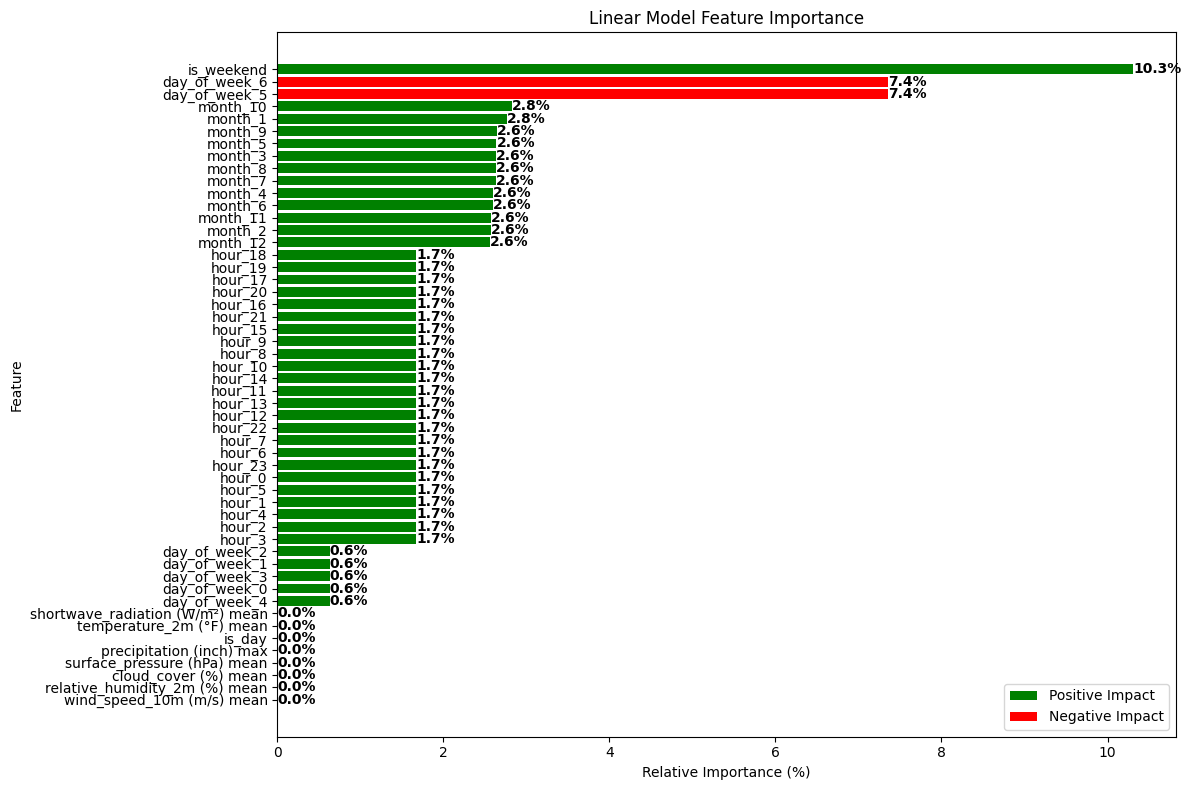

In [ ]:
avg_coef = pd.DataFrame(metrics['coefficients']).mean()
coefficients = np.array(avg_coef).flatten()
feature_names = lr_df.drop(columns=['prelim_load_avg_hourly']).columns

# Create DataFrame with absolute coefficients and names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Calculate relative importance as percentage
importance_df['Relative_Importance'] = (
    importance_df['Abs_Coefficient'] / importance_df['Abs_Coefficient'].sum() * 100
)

# Sort by absolute importance
importance_df = importance_df.sort_values('Relative_Importance', ascending=True)

# Create color map based on coefficient direction
colors = ['green' if c > 0 else 'red' for c in importance_df['Coefficient']]

# Create plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Relative_Importance'], color=colors)

# Add percentage labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%',
            ha='left', va='center', fontsize=10, fontweight='bold')

plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.title('Linear Model Feature Importance')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Positive Impact'),
    Patch(facecolor='red', label='Negative Impact')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

Although we can visually confirm that our model has learned a reasonable shape, these coefficients are not very interpretable.

We can see that our most important features are the encodings of the temporal phenomena. Meanwhile, the weather features are many orders of magnitude less important. This indicates that the linear regression model is hardly utilizing the weather data in its predictions, and is instead just learning the general periodicity of load demand. This is a conclusion that is also reflected in the graph of our forecast as compared to the actual values.

Additionally, it is worth noting that the average intercept is very close to the average value of the load for the training data. It would seem that our linear model has generally fit a semi-sinusoidal wave with an equilibrium in line with the observed average load.

In [ ]:
print(f"Average Intercept: {np.mean(metrics['intercepts']):.2f}")
print(f"Average Load: {y_train.mean():.2f}")
print(f"% Difference: {abs((np.mean(metrics['intercepts'])-y_train.mean())/y_train.mean()):.3%}")

Average Intercept: 30980.97
Average Load: 30875.75
% Difference: 0.341%


### Summary

The linear regression model manages to learn a pattern that mimics load in a broad sense. It may be suitable for longer term forecasts, where exact  precision is less important than the general trend.

However, the model does not capture the relationships between weather and load, leaving us with a very general shape and limited precision. Therefore, it does not appear well-suited for short-term load forecasting, where exact precision is the goal.

Next, we will try XGBoost with several feature engineering methods, which should be better suited to capture nuances of this data.

# XGBoost with Timeseries Feature Engineering

### Preprocess data

The first step is to preprocess our data, which is a simple matter of selecting the proper columns and casting the datetime column type.

In [ ]:
temp_df = primary_df.copy()

# keep only "mean" weather variables, datetime, and load columns
# also keep max precipitation
temp_df = temp_df.loc[:, temp_df.columns.str.contains('mean|datetime_beginning_ept|prelim_load_avg_hourly')]
temp_df['precipitation (inch) max'] = primary_df['precipitation (inch) max']

# drop columns with high multicolinearity (and mean precip)
temp_df = temp_df.drop(columns=['apparent_temperature (°F) mean', 'direct_radiation (W/m²) mean', 'precipitation (inch) mean'])

# ensure dateimte column is of type datetime
temp_df['datetime_beginning_ept'] = pd.to_datetime(temp_df['datetime_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')

Next, we will augment our dataset with features engineered specifically to aid our model.


Choices of engineered features were made through multiple iterations of testing. The following features proved most useful for the model.
- Adding lagged features and rolling averages
    - We keep track of previous load values as well as the load's moving average
    - This allows the model to use previous load data to predict the next load
    - For each step in the forecast horizon, we have to use previously calculated values
        - Therefore, uncertainty grows over time as increasingly distant forecast steps are increasingly dependent on forecasted values
- Adding interaction features
     - We add features that capture the interaction between temperature and temporal patterns.
     -We could create interactions with the other weather variables at the cost of added complexity
        - Temperature interactions proved most useful

- Adding cos/sine features for periodic trends
    - A detailed explanation of these features is given at the end of this section

In [ ]:
# preparing features
processed_df = temp_df.copy()

# convert datetime to pandas datetime
processed_df['datetime_beginning_ept'] = pd.to_datetime(processed_df['datetime_beginning_ept'])
processed_df.set_index('datetime_beginning_ept', inplace=True)

# create interaction features with temperature
    # we could create interactions with other weather features, at the cost of added complexity
    # temperature interactions will be most useful
# hourly interaction
processed_df['hour'] = processed_df.index.hour
processed_df['temp_hour'] = processed_df['temperature_2m (°F) mean'] * processed_df['hour']
# daily interaction
processed_df['day_of_week'] = processed_df.index.dayofweek
processed_df['temp_day_of_week'] = processed_df['temperature_2m (°F) mean'] * processed_df['day_of_week']
# monthly interaction
processed_df['month'] = processed_df.index.month
processed_df['temp_month'] = processed_df['temperature_2m (°F) mean'] * processed_df['month']
processed_df.drop(columns=['hour', 'day_of_week', 'month'], inplace=True)

t = np.array(range(len(processed_df.index)))

# Create dictionaries to store all features
daily_features = {}
weekly_features = {}

# Generate daily features
for harmonic in range(1, 49):
    daily_features[f'sin_daily_{harmonic}'] = np.sin(2 * np.pi * harmonic * t / 24)
    daily_features[f'cos_daily_{harmonic}'] = np.cos(2 * np.pi * harmonic * t / 24)

# Generate weekly features
for harmonic in range(1, 169):
    weekly_features[f'sin_weekly_{harmonic}'] = np.sin(2 * np.pi * harmonic * t / 168)
    weekly_features[f'cos_weekly_{harmonic}'] = np.cos(2 * np.pi * harmonic * t / 168)

# Create Fourier features DataFrame with the same index as processed_df
fourier_features = pd.DataFrame({**daily_features, **weekly_features}, index=processed_df.index)

# Combine while preserving the original columns
processed_df = pd.concat([processed_df.copy(), fourier_features], axis=1)

# drop rows with NaN values from lag creation
processed_df = processed_df.dropna()



Next, we add load rolling averages and lagged load as features. We add these values to the whole dataframe. In practice, we would not know these values while forecasting because they depend on load data we do not yet have.

Therefore, in cross-validation, we need to drop these values from each test window and instead dynamically calculate them for each consecutive timestep into the forecast horizon.

In [ ]:
processed_lagged_df = processed_df.copy()

# prepare lag features
lag_features = {
    f'load_lag_{i}': processed_lagged_df['prelim_load_avg_hourly'].shift(i)
    for i in [1, 24, 48, 168]  # 1 hour, 1 day, 2 days, 1 week
}

# prepare all rolling mean features
rolling_features = {
    f'load_rolling_mean_{window}': processed_lagged_df['prelim_load_avg_hourly'].rolling(window=window).mean()
    for window in [24, 168]  # 24 hours, 1 week
}

# combine all features and add to train_data at once
processed_lagged_df = pd.concat([
    processed_lagged_df,
    pd.DataFrame(lag_features),
    pd.DataFrame(rolling_features)
], axis=1)


### Training

Similar to logistic regression, we need to take a nuanced approach to training this model. We will perform the same timeseries cross-validation within our grid search. This time; however, we will need a slightly more complex set of helper functions to make it possible.

In order to get predictions from this model, we need a custom function. This function forecasts one step at a time, using the last forecasted value to dynamically calculate lagged load and rolling averages.

In [ ]:
def c_xgb_dynamic_predictions(input_model, input_test_data, input_train_data):
   feature_cols = input_test_data.drop(columns=['prelim_load_avg_hourly']).columns
   test_data_dynamic = input_test_data.copy()
   n_steps = len(input_test_data)
   test_predictions = np.zeros(n_steps)

   # initialize first step with known training data values
   for lag in [1, 24, 48, 168]:
       test_data_dynamic.iloc[0, test_data_dynamic.columns.get_loc(f'load_lag_{lag}')] = input_train_data['prelim_load_avg_hourly'].iloc[-lag]

   for window in [24, 168]:
       test_data_dynamic.iloc[0, test_data_dynamic.columns.get_loc(f'load_rolling_mean_{window}')] = input_train_data['prelim_load_avg_hourly'].iloc[-window:].mean()

   # make space for features
   features = np.zeros((1, len(feature_cols)))
   feature_indices = [test_data_dynamic.columns.get_loc(col) for col in feature_cols]

   # Main prediction loop
   for i in range(n_steps):
       # get features for current step
       features[0, :] = test_data_dynamic.iloc[i, feature_indices].values

       # make prediction
       predicted_load = input_model.predict(features)[0]

       test_predictions[i] = predicted_load

       # update future lag values
       for lag in [1, 24, 48, 168]:
           if i + lag < n_steps:
               test_data_dynamic.iloc[i + lag, test_data_dynamic.columns.get_loc(f'load_lag_{lag}')] = predicted_load

       # update future rolling means
       for window in [24, 168]:
           if i + window < n_steps:
               test_data_dynamic.iloc[i + window, test_data_dynamic.columns.get_loc(f'load_rolling_mean_{window}')] = predicted_load

   return test_predictions.tolist()

As described above, this model requires a nuanced training/tuning methodology. To achieve this, we need a custom function that combines grid-search and cross-validation. This function mirrors the one we used for logistic regression, but with modifications to account for this model's unique structure.

The key difference is that we drop lagged load and rolling mean from each test window, since these values rely on unknown values in the forecast horizon. Consequently, we use our custom predict function (defined above) instead of the default model.predict() in order to dynamically calculate lagged load and rolling means as we step further into the forecast horizon.

In [ ]:
def combined_cv_grid_search(df, splits, param_grid):
    best_score = float('inf')
    best_params = None

    # find all parameter combinations
    from itertools import product
    param_combinations = [dict(zip(param_grid.keys(), v))
                         for v in product(*param_grid.values())]

    print(f"Running grid search for {len(param_combinations)} iterations")
    for params in param_combinations:
        # print(f"\tTrying parameters: {params}")
        scores = []
        for window in splits:
            # split df into training and testing data
            split_index = (8760*5 + 24) # first 5 years (2020 is a leap year)
            train_data = df[:split_index+window[0]] # train data is first 5 years + portion of 6th year preceeding the test window
            test_data = df[window[0]+split_index : window[1]+split_index] # test data is a two week window in the 6th year
            feature_cols = df.drop(columns=['prelim_load_avg_hourly']).columns
            X_train = train_data[feature_cols]
            y_train = train_data['prelim_load_avg_hourly']

            # drop unknown values (lagged loag, load rolling mean) from testing data
            test_data['load_rolling_mean_24'] = np.nan
            test_data['load_rolling_mean_168'] = np.nan
            test_data['load_lag_1'] = np.nan
            test_data['load_lag_24'] = np.nan
            test_data['load_lag_48'] = np.nan
            test_data['load_lag_168'] = np.nan

            # fit model up to current test window
            model = xgb.XGBRegressor(**params, random_state=42)
            model.fit(X_train, y_train)

            # predict the test window
            prd = c_xgb_dynamic_predictions(model, test_data, train_data)
            y = test_data["prelim_load_avg_hourly"]

            # store MSE
            mse = mean_squared_error(y, prd)
            scores.append(mse)

        # score for this set of hyperparameters is avg of MSE for the 26 windows
        score = np.mean(scores)

        # save best hyperparameters
        if score < best_score:
            best_score = score
            best_params = params
            best_string = f"Average RMSE: {round(np.sqrt(score), 2)}"
            # print(f"\t\tNew best:\t{best_string}")

    print(f"Final results:\n\tBest parameters: {best_params}\n\t{best_string}")
    return best_params

For each set of hyperparameters, we validate on 26 2-week windows. We consider the best hyperparameters to be those that minimizes the average MSE across the 26 periods.

In [ ]:
# get the indices for 26 periods of 2-weeks periods throughout the year
# this ensures we validate the model over an entire year of data
splits = []
for n in range(0, 26):
    splits.append((336*n, 336*n+336))

Finally, we are ready to do the combined grid-search cross-validation to find the best parameters for the model. The following cell runs a 96 parameter grid-search, which will take multiple hours to execute. Setting run_grid_search to False will skip the grid search and proceed with the saved best parameters.

In [ ]:
# set to True to run grid search
# set to False to use the saved outputs of the grid-search (recommended)
run_grid_search = False

if run_grid_search:

    # hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'gamma': [0, 0.1]
    }

    params = combined_cv_grid_search(processed_lagged_df, splits, param_grid)

else:
    # saved params from grid search
    params = { 'n_estimators': 200,
                'learning_rate': 0.05,
                'max_depth': 9,
                'gamma': 0.1}
    print(f"Final results:\n\tBest parameters: {params}\n\tAverage RMSE: 1720.11")


# create the final XGBoost model with the best hyperparameters
xgb_model_final = xgb.XGBRegressor(
    n_estimators=params['n_estimators'],
    learning_rate=params['learning_rate'],
    max_depth=params['max_depth'],
    gamma=params['gamma'],
    random_state=42
)


Final results:
	Best parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 9, 'gamma': 0.1}
	Average RMSE: 1720.11


Our linear regerssion model achieved an Average RMSE of 2837.31 in the same cross-validation. Therefore, XGBoost improved performance by over 1,000 MWh on average across the validation windows.

### Statistical Analysis

For the rest of our analysis, we will look at the best model's performance in the last two weeks of 2023, mirroring the analysis portion of the linear regression model.

In [ ]:
# fit final model on all of the data apart from last 2 weeks
train_data = processed_lagged_df[:-336]
test_data = processed_lagged_df[-336:]
X_train_full = train_data.drop(columns=['prelim_load_avg_hourly'])
y_train_full = train_data['prelim_load_avg_hourly']
xgb_model_final.fit(X_train_full, y_train_full)

# to see how well fit the model was, we can use the model.predict() function
train_predictions = xgb_model_final.predict(X_train_full)
# to make forecast predictions, we have to use our custom function
test_predictions = c_xgb_dynamic_predictions(xgb_model_final, test_data, train_data)

Next, let's print the basic performance metrics for a quick comparison to linear regression.

In [ ]:
# training accuracy
rmse = np.sqrt(mean_squared_error(y_train_full, train_predictions))
mape = mean_absolute_percentage_error(y_train_full, train_predictions)*100
r2 = r2_score(y_train_full, train_predictions)
print("Training Results:")
print(f"\tThe training resulted in a RMSE of {round(rmse, 2)}. \n\tThe mean absolute percent error was {round(mape, 2)}%. \n\tThe model explains about {round(r2*100, 2)}% of the variance in load.")

# validation
rmse = np.sqrt(mean_squared_error(test_data['prelim_load_avg_hourly'], test_predictions))
mape = mean_absolute_percentage_error(test_data['prelim_load_avg_hourly'], test_predictions)*100
r2 = r2_score(test_data['prelim_load_avg_hourly'], test_predictions)
print("Validation Accuracy:")
print(f"\tThe training resulted in a RMSE of {round(rmse, 2)}. \n\tThe mean absolute percent error was {round(mape, 2)}%. \n\tThe model explains about {round(r2*100, 2)}% of the variance in load.")

Training Results:
	The training resulted in a RMSE of 162.42. 
	The mean absolute percent error was 0.39%. 
	The model explains about 99.93% of the variance in load.
Validation Accuracy:
	The training resulted in a RMSE of 1454.41. 
	The mean absolute percent error was 3.65%. 
	The model explains about 81.47% of the variance in load.


Based on these numbers, this model outperforms the linear regression model across the board.

However, we do see a pronounced drop-off between our training and validation statistics. These results are expected due to the nature of short-term forecasting. It is evidence that the model has precisely interpolated the training data, which is exactly what enables it to out-perform linear regression in the forecast window.

On the other hand, linear regression did a poor job of interpolating the training data, which resulted in improved performance in the testing window (relative to training, by mere coincidence) but significantly worse performance overall compared to the XGBoost model.

As before, we can plot our forecast against the actual values to visually assess performance.

##### Figure 8

In [ ]:
plot_forecast_plotly(test_data['prelim_load_avg_hourly'], test_predictions, test_data.index)

The forecast results line up very closely with the actual values. This model does a better job of filling in the peaks/troughs as compared to linear regression.

Again, we can plot the differences to expose any systematic error.

##### Figure 9

In [ ]:
plot_difference_plotly(test_data['prelim_load_avg_hourly'], test_predictions, test_data.index)

The observed differences are within roughly +/- 5,000 MWh, and there are no signs of systematic error.

Given the recursive nature of our model (using the last forecasted value to forecast the time step), we would expect our model to become less accurate over time. We can check whether that is the case by plotting the absolute value of the differences over time.

##### Fig 10.

In [ ]:
plot_difference_plotly(test_data['prelim_load_avg_hourly'], test_predictions, test_data.index, use_abs=True)

Based on this 2-week window, there does not appear to be a systematic drop-off in accuracy over time. If we wanted to use this same model to forecast an entire year, the forecast decay would likely become more apparent.

This is a good sign for our model as it is apparently well-suited for these 2-week forecasts.

### Feature Importance Analysis

Finally, we can do some feature importance analysis to get a sense for how our model managed to interpolate the data more precisely than the linear regression model.

In [ ]:
def plot_xgb_feature_imporance(importance_scores, feature_cols):
    # Convert to DataFrame
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    importance_df = importance_df.head(20)

    # Map feature names
    feature_map = {f'f{i}': name for i, name in enumerate(feature_cols)}
    importance_df['Feature'] = importance_df['Feature'].map(lambda x: feature_map.get(x, x))

    # Calculate relative importance
    importance_df['Relative_Importance'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Relative_Importance'])
    plt.xlabel('Relative Importance (%)')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

##### Figure 11

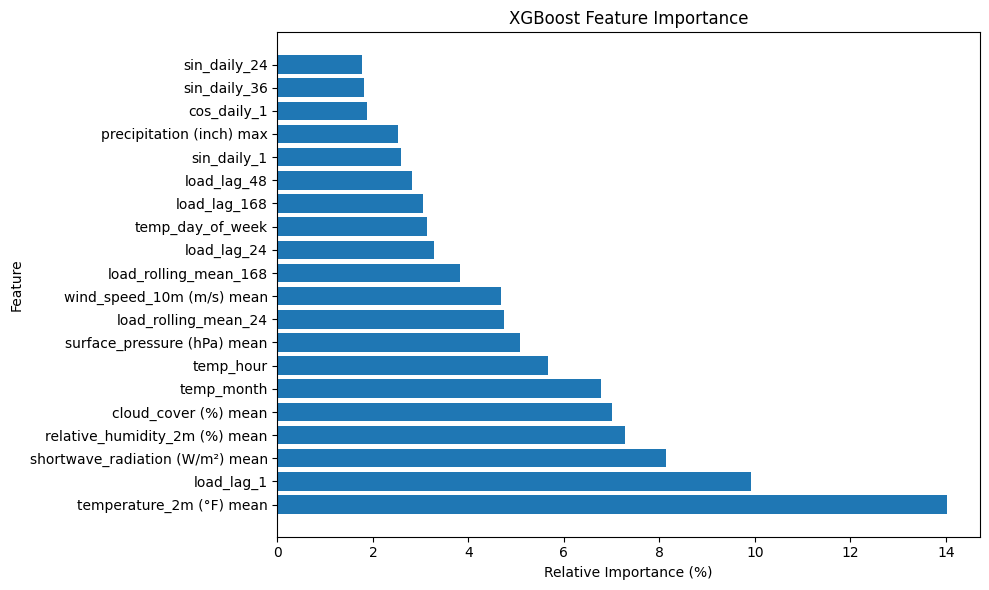

In [ ]:
# plotting the 20 most important features
feature_cols = processed_lagged_df.drop(columns=['prelim_load_avg_hourly']).columns
plot_xgb_feature_imporance(xgb_model_final.get_booster().get_score(importance_type='weight'), feature_cols)

In comparison to the linear regression model, these coefficients are far more interpretable. We can immediately see that our weather variables are being properly utilized by the model.
<br><br>

The most important feature is temperature, which aligns with our aforementioned logic. To reiterate, extreme temperatures result in higher electricity demand as people spend less time outdoors, and more time in air-conditioned spaces, partaking in more electricity demanding activities.
<br><br>
Another interesting takeaway is that precipitation is much less important than the other weather features. This is likely a result of the precipitation data being sparse, which is the inherent nature of precipitation. These results indicate that its inclusion in the model may not be particularly useful.
<br><br>
The second most important feature is 1-lagged load. Load typically does not change dramatically from one hour to the next, so it makes sense that our model benefits greatly from being enabled with the previous load value. It should be noted that this feature is dynamically updated as the forecast steps further into the future. This means that the uncertainty in this value grows over time. As a result, we expect to see performance drop systematically over time. However, this trend does not show up in Fig. 10 (above).
<br><br>
Meanwhile, many of the temporal periodic features we introduced appear to have lower importance. It should be noted that these cos/sin features are actually intended to work together. The linear combination of these features is equivalent to a [Fourier transform](https://eepower.com/technical-articles/harmonics-analysis-using-fourier-to-analyze-waveforms/), and can be interpreted as a single wave that captures the periodicity of the training data. So, while these features may have lower importance individually, it is actually the resulting harmonic shape that is significant.


### Fourier Analysis

We can expose the harmonic shape of the combined Fourier features using the coefficients from the model

In [ ]:
# plot linear combination of sin/cos features
coefs = xgb_model_final.feature_importances_
fourier_dict = {feature: coef for feature, coef in zip(feature_cols, coefs) if 'sin' in feature or 'cos' in feature}
f_wave = 0
for harmonic in range(1, 49):
    f_wave += (fourier_dict[f'sin_daily_{harmonic}'] * np.sin(2 * np.pi * harmonic * t / 24))
    f_wave += (fourier_dict[f'cos_daily_{harmonic}'] * np.cos(2 * np.pi * harmonic * t / 24))

for harmonic in range(1, 169):
    f_wave += (fourier_dict[f'sin_weekly_{harmonic}'] * np.sin(2 * np.pi * harmonic * t / 168))
    f_wave += (fourier_dict[f'cos_weekly_{harmonic}'] * np.cos(2 * np.pi * harmonic * t / 168))

We can do an additional linear transform to this wave to scale it up before comparing to our data. Conveniently, we do not have to guess which transform will get us there, we can use linear regression!

In [ ]:
# LR model learns one coeficient (scalar transform) and one intercept (translational transform)
lr_fourier = LinearRegression().fit(f_wave.reshape(-1, 1), primary_df['prelim_load_avg_hourly'])
# apply the transform to our wave
f_wave = (f_wave * lr_fourier.coef_) + lr_fourier.intercept_

##### Figure 12

In [ ]:
# plot the wave at a random week
rand_week = np.random.randint(0, len(primary_df) - 168)

plot_forecast_plotly(primary_df['prelim_load_avg_hourly'][rand_week:rand_week+168], f_wave[rand_week:rand_week+168], primary_df['datetime_beginning_ept'][rand_week:rand_week+168], "Implicit Fourier Harmonic vs Actual Values")

This relationship is neat! Our model has implicitly learned a linear combination of the cosine and sine features such that the resulting Fourier harmonic roughly matches the load data, at least in terms of periodicity.

Try running the above code again to get another random week from the data. In every case, the Fourier harmonic's peaks and troughs line up roughly with the peaks and troughs of the actual load.

Of course, this would constitute a very rough forecast on its own, which is where our model utilizes the other features.  

### Summary

This model does an much better job than linear regression. Using XGBoost, several engineered features, and a recursive structure, we manage to capture a lot more information about the relationship between load demand and weather. But is this good enough for commercial use?
<br><br>
In our worst cases of over-predicting, we would be wasting almost 15% of the electricity produced. This wasted electricity results in unnecessary monetary and ecological costs. From some rough calculations, this error would result in millions of pound of excess carbon emissions.
<br><br>
The cases where we under-predicted load are more alarming. Failing to meet electricity demand can lead to devastating blackouts - risking the lives of people dependent on medical devices while inflicting severe economic damage through disrupted business operations and lost productivity. On December 19th at 1pm, we under-predicted by almost 1,600 MWh. It is possible to respond to this discrepancy by spinning up additional generation units throughout the day, but this will result in operating these units outside the ranges of their optimal efficiency curves. Again, we would have to accept excess costs and carbon emissions which may have been avoided with a better forecast.
<br><br>
Additionally, companies like PJM cannot simply flip a switch to activate additional generation units. It can take several minutes or hours for a unit to spin up to full capacity, but it only takes a moment for an over-capacity grid to trigger a blackout.
<br><br>
Typically, power companies will plan to generate more energy than the forecast predicts in order to minimize the chances of a blackout. Therefore, being off by a few hundred MWh is probably acceptable. However, with more precise and reliable forecasts, we might get away with smaller buffers.
<br><br>
In turn, if we had to consistently build in a buffer of ~1,800 MWh to account for our worst-case, then we would be consistently wasting ~5% of generated electricity, which is both costly and wasteful. On the other hand, if we went with a smaller buffer, December 19th may have triggered an even more costly (not to mention life-threatening) blackout. This example underscores the value of precision and robustness in modeling load.
<br><br>
In the next section, we will test a cutting edge Auto-regressive LSTM to see whether it's deep-learning can improve upon these results.

# Auto-regressive LSTM

### Data Preprocessing and Training Initialization

In this section, we train and evaluate an Auto-regressive Long Short-Term Memory model (AR LSTM). At a high level, this model can be best understood as an Neural Network specifically designed to capture patterns innate to timeseries data (similar to how a CNN is geared towards image processing).

Once again, we start with some basic preprocessing steps. We create columns to encode the distance of each data point from the beginning of our dataset, which helps the model understand the sequentiality of the data.

In [ ]:
# noting the list of features at this stage
features = ['temperature_2m (°F) mean',
       'relative_humidity_2m (%) mean', 'surface_pressure (hPa) mean',
       'cloud_cover (%) mean', 'wind_speed_10m (m/s) mean',
       'shortwave_radiation (W/m²) mean', 'precipitation (inch) max', 'hour',
       'day_of_week', 'month', 'is_weekend']
times_df = processed_df.copy()

# annotating dataframe with timestamps as integer values from start
earliest_time = times_df.index.min()
times_df['hours_from_start'] = (times_df.index - earliest_time).seconds / 60 /60 + (times_df.index - earliest_time).days * 24
times_df['hours_from_start'] = times_df['hours_from_start'].astype(int)
times_df['days_from_start'] = (times_df.index - earliest_time).days

# casting type of categorical columns so LSTM treats them accordingly
times_df['hour'] = times_df.index.hour.astype(str).astype('category') # type: ignore
times_df['day_of_week'] = times_df.index.dayofweek.astype(str).astype('category') # type: ignore
times_df['month'] = times_df.index.month.astype(str).astype('category') # type: ignore
times_df['is_weekend'] = times_df.index.dayofweek.astype(str).astype('category') # type: ignore

We are now ready to begin setting up the model using the tools provided by the pytorch-forecasting libraries.

The next cell sets up the following:
- Forecast sequence length
- Encoding length
- Train and testing splits
- Training batch size

One of the key notes at this point is that we are stuck with 24-hour forecast sequences. While our previous models were configured to produce 14-day forecasts, the LSTM is not suited for predictions of this length. We discuss the details of this limitation in further detail towards the end of this section.

In [ ]:
# predict one day
max_prediction_length = 24

max_encoder_length = 7*24

training_cutoff = times_df['hours_from_start'].max() - max_prediction_length


training = TimeSeriesDataSet(
    times_df[lambda x: x.hours_from_start <= training_cutoff],
    # we use hours_from_start as the time index since the model cannot directly intrepret our datetime column
    time_idx="hours_from_start",
    target="prelim_load_avg_hourly",
    group_ids=["month"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    # declare categorical variables
    time_varying_known_categoricals=['hour','day_of_week', 'month', 'is_weekend'],
    # declare weather features
    time_varying_known_reals=["hours_from_start", "days_from_start", 'temperature_2m (°F) mean',
       'relative_humidity_2m (%) mean', 'surface_pressure (hPa) mean',
       'cloud_cover (%) mean', 'wind_speed_10m (m/s) mean',
       'shortwave_radiation (W/m²) mean', 'precipitation (inch) max'],
    time_varying_unknown_categoricals=[],
    # declare target variable
    time_varying_unknown_reals=["prelim_load_avg_hourly"],
    target_normalizer=EncoderNormalizer(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, times_df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64
# send data to dataloaders for GPU optimization
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=32,batch_sampler="synchronized")
train_val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=32, batch_sampler="synchronized")
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=32, batch_sampler="synchronized")

This next cell sets up and initializes a DeepAR model for time series forecasting using PyTorch Lightning.

We start by initializing the training process to use GPU resources. One of the persisting issues we faced with this model was divergence of the gradient during training. We therefore set up gradient clipping, which helps avoid this issue.

We also define some of the key hyperparamers, such as a learning rate of 0.001, a hidden size of 24, and a multivariate normal loss function for probabilistic predictions.

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.9,
    #max_epochs=20,
)


net = DeepAR.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.001,
    hidden_size=24,  # set to <= hidden_size
    loss=MultivariateNormalDistributionLoss(rank=8),
    rnn_layers=2,
)
print(f"Number of parameters in network: {net.size() / 1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Number of parameters in network: 11.6k


Tuning the learning rate turn was a crucial step for our AR LSTM. To ensure stability in training, we used PyTorch Lightning's Tuner class to automatically find the optimal learning rate through a range test. This method starts with a very small learning rate and gradually increases it, monitoring the loss function at each step.

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 0.0031622776601683794


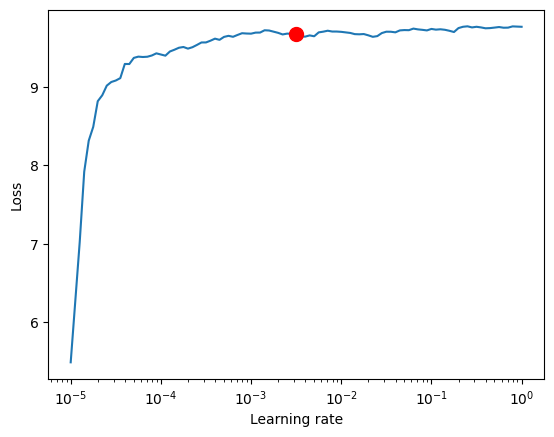

In [ ]:
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1e0,
    min_lr=1e-5,
    early_stop_threshold=100
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

The process described above suggests a learning rate of about 0.003 for optimal and stable training.



### Training

The next cell finalizes our training setup, using the hyperparameters discussed above. We declare the maximum number of epochs to be 50, but in practice, early stopping is triggered after 20 epochs.

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=4, verbose=True, mode="min")
lr_logger = LearningRateMonitor(logging_interval='step', log_momentum=True)  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.9,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

net = DeepAR.from_dataset(
    training,
    learning_rate=0.003, # use the suggested learning rate
    hidden_size=24,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=8)
)

Due to resource limitations within Google Colab, we aren't able to train our LSTM model within the notebook.

We trained the model using a NVIDIA A6000 GPU, which took around 10 hours. With the T4 chip provided in the Colab environment, training would likely take over 20 hours. For simplicity, we import the model from a TensorBoard checkpoint.

In [ ]:
best_model_path = "./data/checkpoint/epoch=20-step=938448.ckpt"
best_model = DeepAR.load_from_checkpoint(best_model_path)
best_model.eval()

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dataset_parameters":                {'time_idx': 'hours_from_start', 'target': 'prelim_load_avg_hourly', 'group_ids': ['month'], 'weight': None, 'max_encoder_length': 168, 'min_encoder_length': 84, 'min_prediction_idx': 0, 'min_prediction_length': 24, 'max_prediction_length': 24, 'static_categoricals': None, 'static_reals': None, 'time_varying_known_categoricals': ['hour', 'day_of_week', 'month', 'is_weekend'], 'time_varying_known_reals': ['hours_from_start', 'days_from_start', 'temperature_2m (°F) mean', 'relative_humidity_2m (%) mean', 'surface_pressure (hPa) mean', 'cloud_cover (%) mean', 'wind_speed_10m (m/s) mean', 'shortwave_radiation (W/m²) mean', 'precipitation (inch) max'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['prelim_load_avg_hourly'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': None, 'add_

The output above details the features of our best LSTM model which we use for the rest of the LSTM analysis.

### Analysis

Training loss is visualized over a series of steps by first applying exponential smoothing to the raw loss values, using a smoothing factor of 0.6. This smoothing reduces fluctuations in the data, making the underlying trend more apparent.

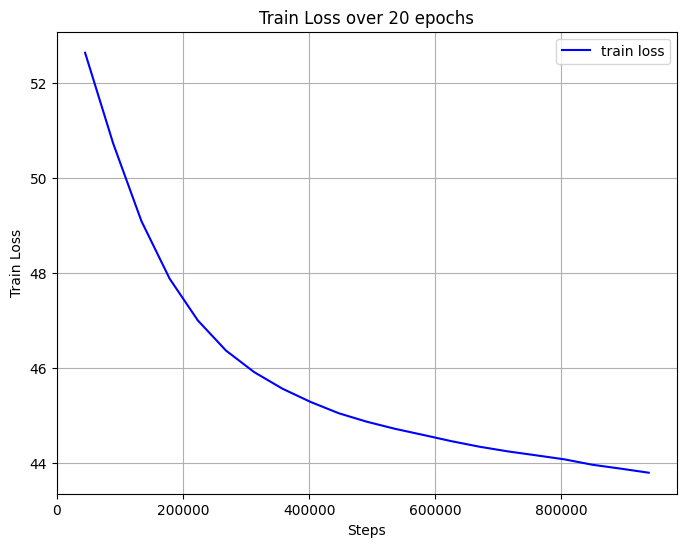

In [ ]:
# read in training data
file_path = './data/checkpoint/train_loss_epoch.csv'
data = pd.read_csv(file_path)

steps = data['Step']
values = data['Value']

smoothing_factor = 0.6
smoothed_values_06 = []
last_value = values.iloc[0]
# apply smoothing
for value in values:
    smoothed_value = smoothing_factor * last_value + (1 - smoothing_factor) * value
    smoothed_values_06.append(smoothed_value)
    last_value = smoothed_value

# Plot the smoothed data with reduced smoothing factor
plt.figure(figsize=(8, 6))
plt.plot(steps, smoothed_values_06, label='train loss', color='blue')
plt.xlabel('Steps')
plt.ylabel('Train Loss')
plt.title('Train Loss over 20 epochs')
plt.legend()
plt.grid(True)
plt.show()

The training loss curve above is typical of a neural network. The model learns quickly in the earlier stages of training and begins to plateau in the later stages.

Next, we print the model's validation RMSE and MAPE to see how it progresses over the 20 epochs.

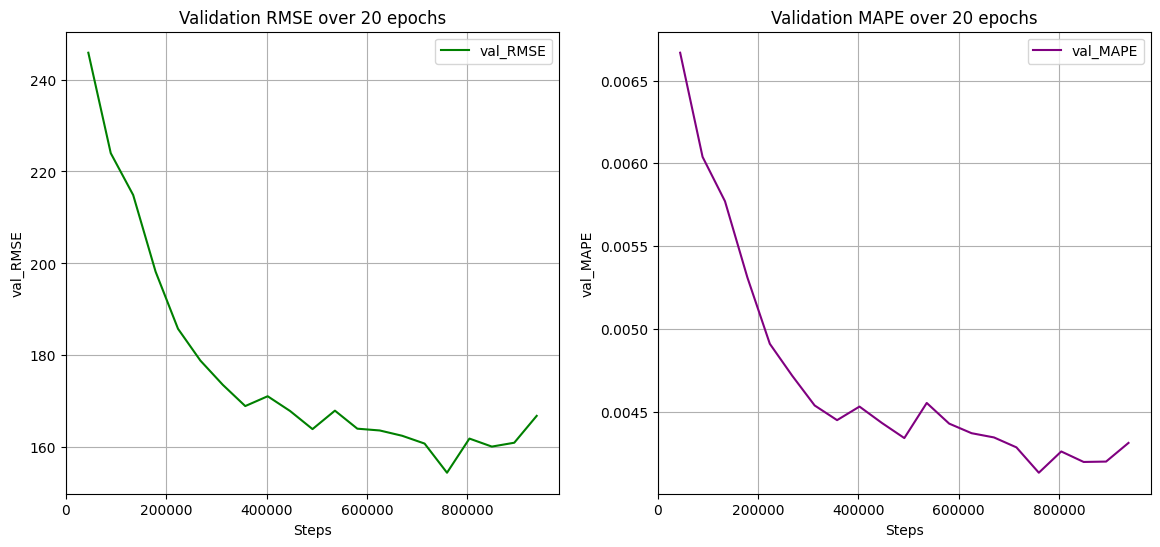

In [ ]:
# read validation data
val_rmse_path = './data/checkpoint/val_RMSE.csv'
val_mape_path = './data/checkpoint/val_MAPE.csv'
val_rmse_data = pd.read_csv(val_rmse_path)
val_mape_data = pd.read_csv(val_mape_path)

val_rmse_steps = val_rmse_data['Step']
val_rmse_values = val_rmse_data['Value']
val_mape_steps = val_mape_data['Step']
val_mape_values = val_mape_data['Value']

# Apply smoothing with a factor of 0.6 for RMSE
smoothing_factor = 0.6
smoothed_val_rmse = []
last_value = val_rmse_values.iloc[0]

for value in val_rmse_values:
    smoothed_value = smoothing_factor * last_value + (1 - smoothing_factor) * value
    smoothed_val_rmse.append(smoothed_value)
    last_value = smoothed_value

# Apply smoothing with a factor of 0.6 for MAPE
smoothed_val_mape = []
last_value = val_mape_values.iloc[0]

for value in val_mape_values:
    smoothed_value = smoothing_factor * last_value + (1 - smoothing_factor) * value
    smoothed_val_mape.append(smoothed_value)
    last_value = smoothed_value

# Plot smoothed val_RMSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(val_rmse_steps, smoothed_val_rmse, label='val_RMSE', color='green')
plt.xlabel('Steps')
plt.ylabel('val_RMSE')
plt.title('Validation RMSE over 20 epochs')
plt.legend()
plt.grid(True)
# Plotting MAPE
plt.subplot(1, 2, 2)
plt.plot(val_mape_steps, smoothed_val_mape, label='val_MAPE', color='purple')
plt.xlabel('Steps')
plt.ylabel('val_MAPE')
plt.title('Validation MAPE over 20 epochs')
plt.legend()
plt.grid(True)
plt.show()

We see that the validation mirror the training loss over the 20 epochs. The key difference is that while training loss declines monotonically, the validation metrics are minimized in the region of ~750,000 steps, and begin to increase before the end of training. This may be a sign that the model was beginning to overfit, so it would seem early stopping was triggered at an appropriate time.

Next, lets print the final validation metrics.

In [ ]:
predictions = best_model.predict(val_dataloader)
actuals = torch.cat([y.cuda() for x, (y, weight) in iter(val_dataloader)])

rmse = RMSE()(predictions,actuals).item()
mape = MAPE()(predictions, actuals).item()
r2 = r2_score(actuals.cpu().numpy(), predictions.cpu().numpy())
print("Validation metrics:")
print(f"\tThe model yielded a RMSE of {round(rmse, 2)}. \n\tThe mean absolute percent error was {round(mape*100, 2)}%. \n\tThe model explains about {round(r2*100, 2)}% of the variance in load.")

Validation metrics:
	The model yielded a RMSE of 1297.02. 
	The mean absolute percent error was 3.15%. 
	The model explains about 87.89% of the variance in load.


Due to differing forecast sequence lengths, we cannot directly compare this model to our previous models. For what it is worth, the model offers exceptional precision within the 24-hour forecast horizon.

Below, we plot 10 example forecasts from the model for visual analysis.

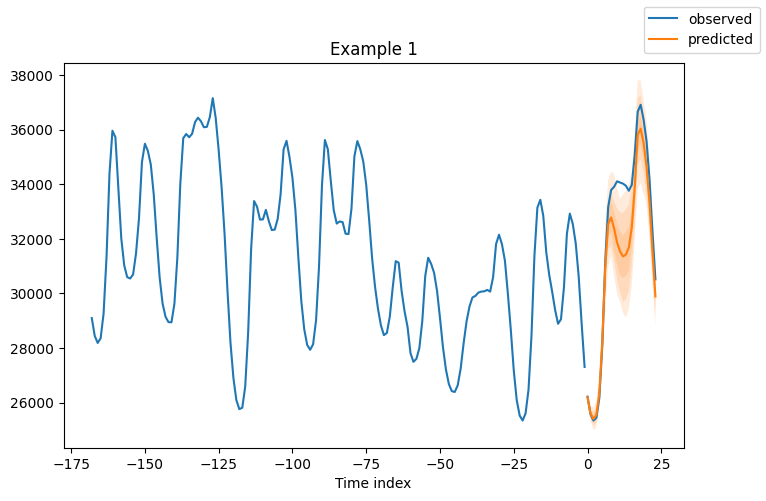

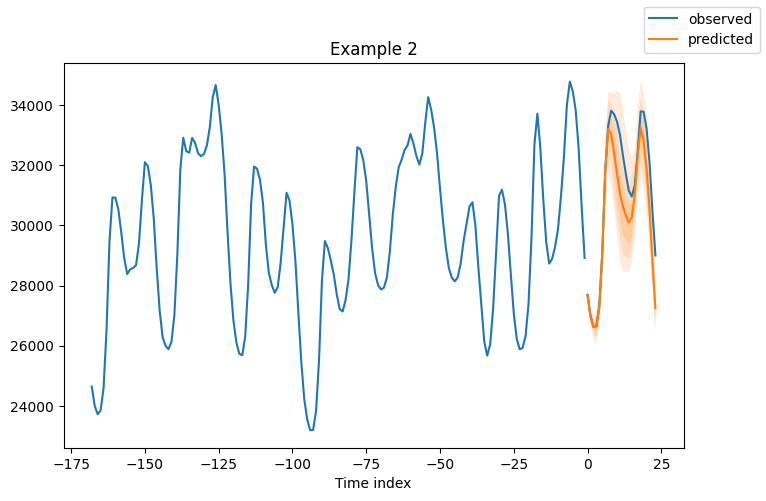

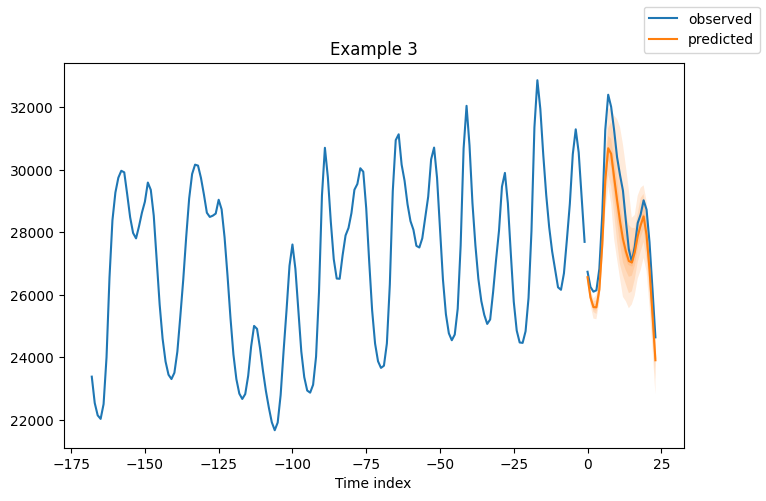

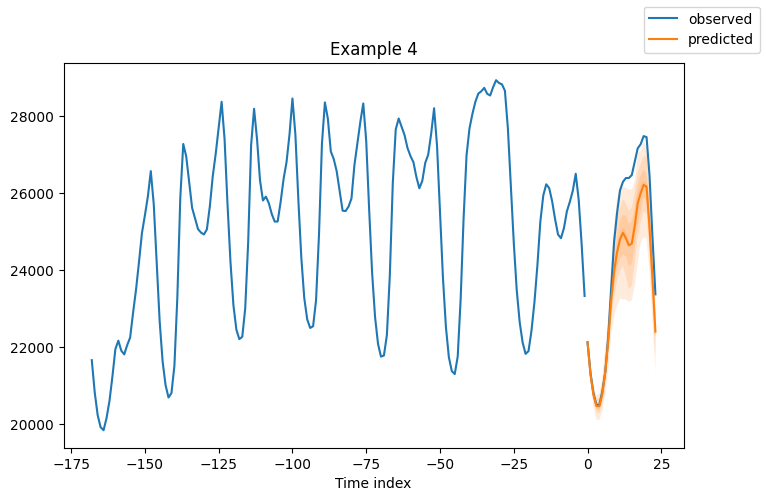

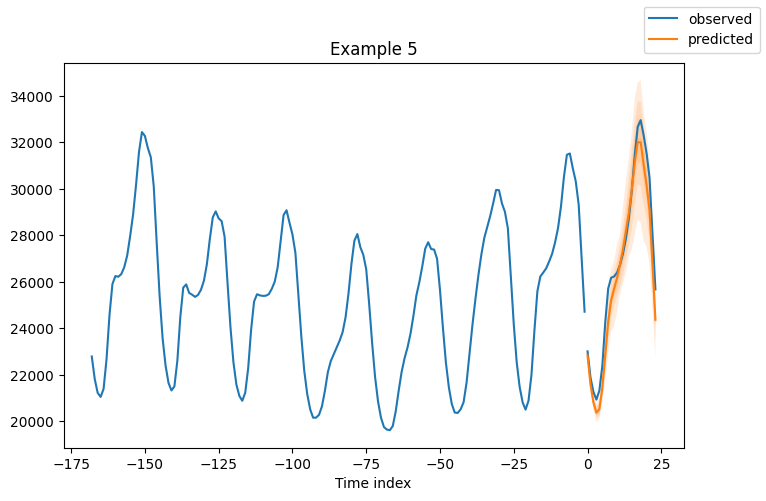

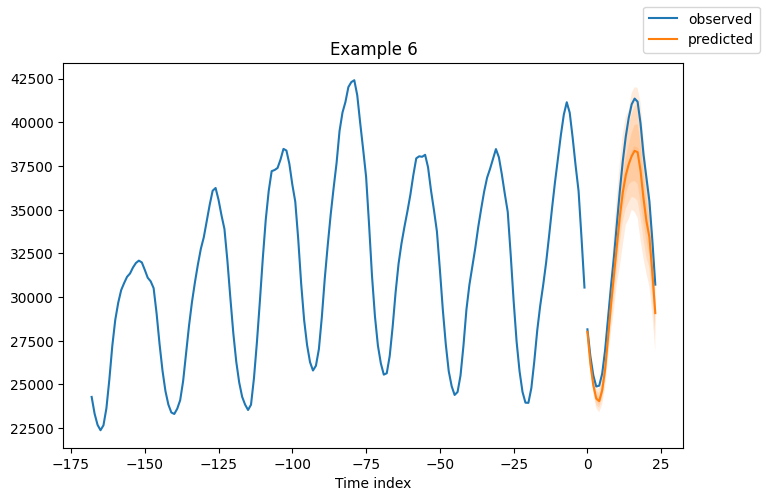

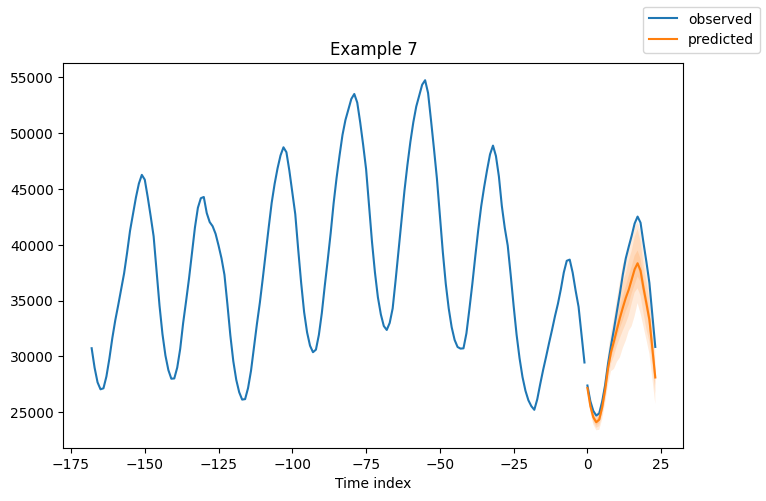

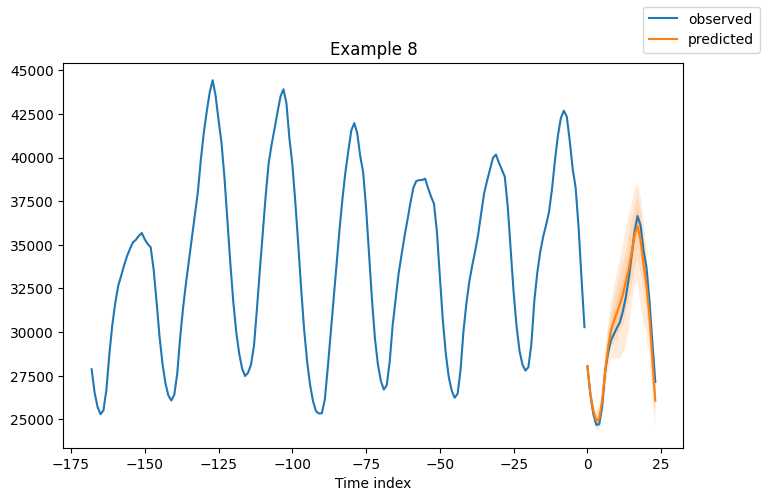

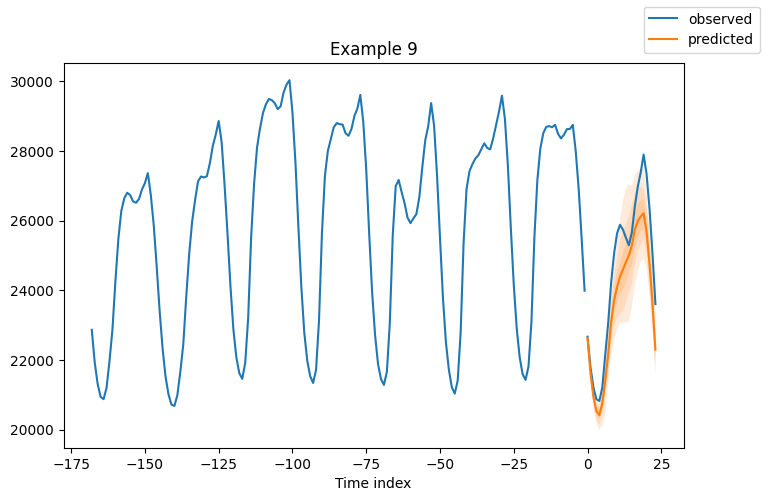

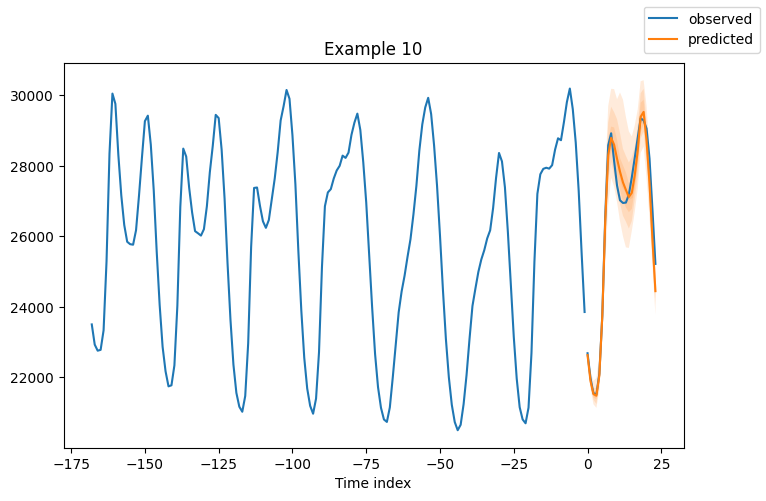

In [ ]:
raw_predictions= best_model.predict(val_dataloader, mode="raw", return_x=True)
# plot 10 examples
for idx in range(10):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False, ax=ax)
    plt.title(f'Example {idx+1}')
    plt.show()

While the performance metrics seem extremely promising, these figures reveal another shortcoming of the model. We see periods of time where the forecast almost perfectly overlaps the actual load; however, there are several examples of the model under-predicting load by a significant margin (Examples 1, 4, and 7). On the other hand, XGBoost rarely lines up as perfectly with the actual values, but ultimately achieves similar RMSE/MAPE scores.

The implication here is that in moments where LSTM misses the mark, it misses by a large enough margin that there is no clear advantage to this model over XGBoost. However, in the periods of time where LSTM hits the mark, it offers the best precision we have seen so far. This detail informs a possible alternative use for the LSTM, which we discuss in the next section.

### Summary and Limitations

Discussion of this model requires acknowledging its key limitation. Although our inital goal was to generate a 14-day forecast, we found ourselves limited to 24-hour forecast sequences. As a result, we cannot directly compare this model with our previous efforts.

The reason for the limited forecast horizon is closely tied to the advanced complexity of this model architecture. Specifically, backpropagation fails as the forecast sequence approaches 50. In order to generate a 2-week forecast, we would have to sacrifice hourly temporal resolution, making the forecast all but useless for electric utility planning.

On the other hand, the model's performance in the 24-hour window is extremely promising. Perhaps this model could be tuned as an early-warning system. Power companies could run the model throughout the day, providing alerts when load demand is on track to exceed capacity. For scenarios like this, a few hours heads-up can give power companies enough time to spin up additional generation units and avoid a blackout.

# Comparing with PJM's model


PJM store their historic load forecasts dating back several years. Therefore, we can compare our best model, XGBoost, with PJM's forecasts for the two weeks of December 2023. Unfortunately, due to the modeling constraints of the LSTM, it must be left out of this analysis.

First, we need to clean up this data before plotting their forecast against ours.

In [ ]:
# read data into dataframe
pjm_fc_df = pd.read_csv("./data/pjm_forecast.csv")

# keep only the necessary rows and filter to MIDATL region
pjm_fc_df = pjm_fc_df[pjm_fc_df['forecast_area'] == "MIDATL"]
pjm_fc_df.drop(columns=['forecast_hour_beginning_utc', 'evaluated_at_utc', 'forecast_area'], inplace=True)
pjm_fc_df.reset_index(drop=True, inplace=True)
pjm_fc_df.drop_duplicates(inplace=True)

# ensure dateimte column is of type datetime
pjm_fc_df['forecast_hour_beginning_ept'] = pd.to_datetime(pjm_fc_df['forecast_hour_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')

# set datetime as the index
pjm_fc_df.set_index('forecast_hour_beginning_ept', inplace=True)

# ensure datetime is sorted
pjm_fc_df.sort_index(inplace=True)

# valid dates
dates = ['12/17/2023 11:45:00 PM', '12/18/2023 11:45:00 PM', '12/19/2023 11:45:00 PM',
         '12/20/2023 11:45:00 PM', '12/21/2023 11:45:00 PM', '12/22/2023 11:45:00 PM',
         '12/23/2023 11:45:00 PM', '12/24/2023 11:45:00 PM', '12/25/2023 11:45:00 PM',
         '12/26/2023 11:45:00 PM', '12/27/2023 11:45:00 PM', '12/28/2023 11:45:00 PM',
         '12/29/2023 11:45:00 PM', '12/30/2023 11:45:00 PM', '12/31/2023 11:45:00 PM', ]
# keep necessary rows
pjm_fc_df = pjm_fc_df[(pjm_fc_df['evaluated_at_ept'].isin(dates))]
pjm_fc_df = pjm_fc_df[~pjm_fc_df.index.duplicated(keep='first')].drop(columns=['evaluated_at_ept'])

Lastly, we can compare the forecasts.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pjm_fc_df.index,
    y=pjm_fc_df['forecast_load_mw'],
    mode='lines',
    name='PJM Forecast'
))

fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_predictions,
    mode='lines',
    name='XGBoost Forecast'
))

fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data['prelim_load_avg_hourly'],
    mode='lines',
    name='Actual'
))

fig.update_layout(
    title='Final Forecasts Comparison',
    xaxis_title='Date',
    yaxis_title='Load',
    legend=dict(x=0.02, y=0.98, orientation='h'),
    hovermode='x',
    template='plotly_white'
)
fig.show()

The first note for this figure is that PJM's historic forecast data is missing values for Dec. 25th, 2023. It is unclear why this data is missing, though we suspect they may take different approaches to modeling for key holidays, which may break away from general trends.

Apart from that detail, our XGBoost model is remarkably similar to PJM's short-term load forecast in this window. There are few cases where PJM's model is considerably more accurate than our model, but there are also a handful of cases where XGBoost outperforms PJM's model.

 This would seem to indicate that our models may have similar architectures, or at the very least, they have learned similar relationships between the given features and load demand.

These results come as a pleasant surprise. In short, our model is remarkably close to the industry standard.

# Analyses and Conclusions


In this section, we compile our final conclusions, assessing the pros and cons for each model.

  

### Linear Regression


---


The Linear Regression approach successfully learns general periodic trends in the data and captures the overall shape. This could make it suitable for long-term forecasting scenarios. However, feature importance analysis reveals critical shortcoming: the model completely ignores weather features, as shown  and instead relies solely on temporal patterns.

This fundamental flaw means it lacks the precision needed for short-term predictions and will be unable to achieve the required accuracy for electric utility planning.

###XGBoost



---



The XGBoost model emerges as our most effective solution for short-term forecasting, demonstrating remarkable accuracy with an average deviation of just 3.65% in the final test window. Its predictions closely track the observed data patterns, and the feature importance analysis reveals sophisticated use of both lagged values and temperature features. Notably, the model's performance closely matches that of PJM's own forecasting system, which lends creedence to its reliability and effectiveness.


### Auto-regressive LSTM




---

The LSTM model demonstrates superior performance within its 24-hour forecast window, slightly outperforming even XGBoost in accuracy. However, this comes with a significant limitation: the model can only generate predictions for a 24-hour sequence due to the instability of backpropagation. The model could still be valuable as an early-warning system, but the restricted forecast horizon means it falls short for comprehensive short-term planning needs.


# Future Research

For future research, the primary focus should be on enhancing the XGBoost model, given its proven effectiveness, speed, flexibility, and interpretability. This could involve experimenting with additional engineered features, expanding the training dataset, and broadening the hyperparameter search space. While more complex models could be explored, they're unlikely to offer sufficient advantages to justify moving away from XGBoost's robust framework.

On the other hand, the LSTM model, despite its limitations, deserves continued development specifically as an early-warning system. Its pinpoint precision over 24-hours makes it valuable for alerting power companies to potential blackout risks, enabling proactive responses such as activating additional generation units.